/tmp/ipython-input-3263683981.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=True, labels=labels, showmeans=True)


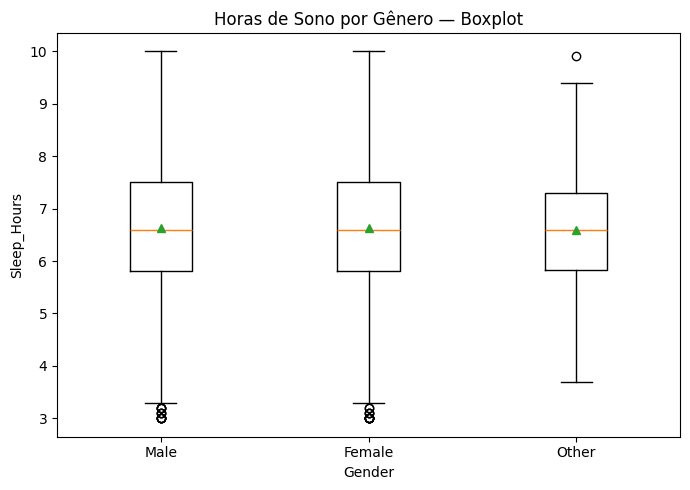

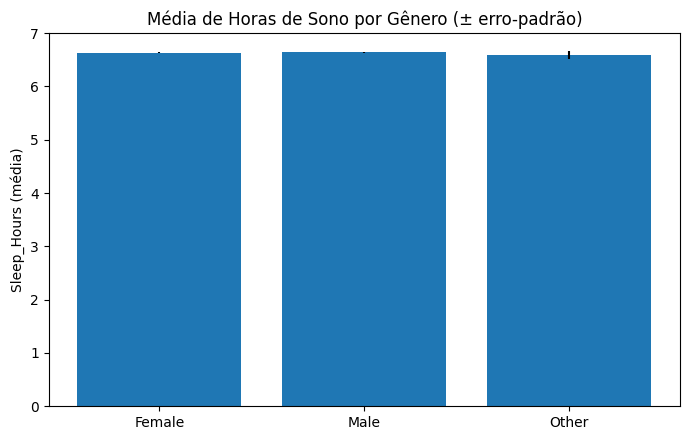

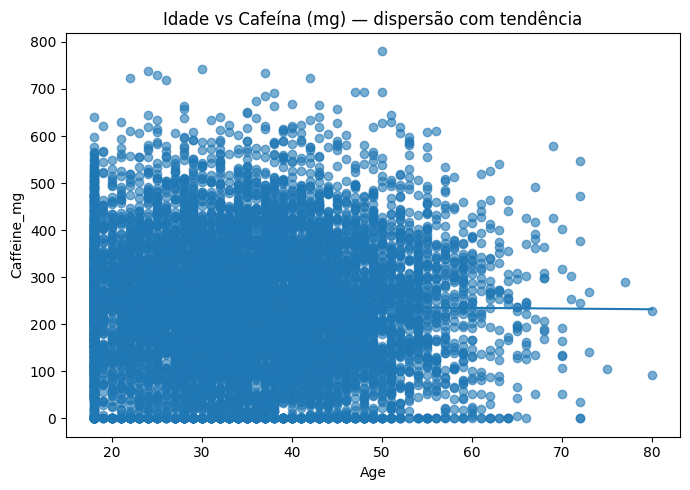

/tmp/ipython-input-3263683981.py:119: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_sono = df.pivot_table(index="Age_Group", columns="_Stress_Ord", values=col_sleep, aggfunc="mean")


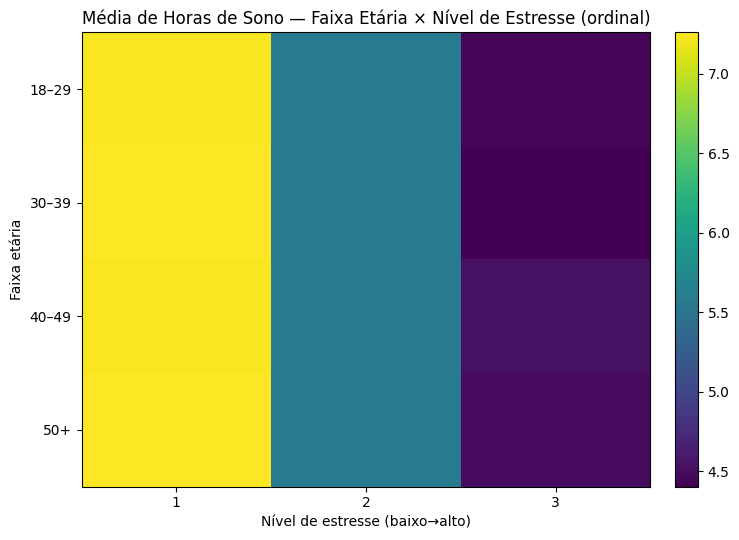

/tmp/ipython-input-3263683981.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_q = sub.groupby("Caffeine_Quartile")[col_sleep].mean()


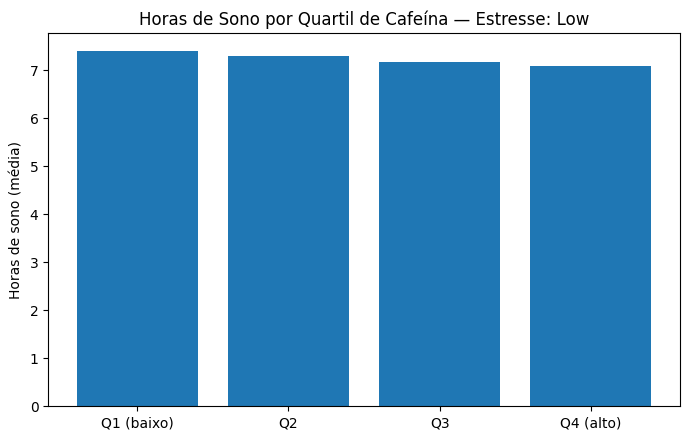

/tmp/ipython-input-3263683981.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_q = sub.groupby("Caffeine_Quartile")[col_sleep].mean()


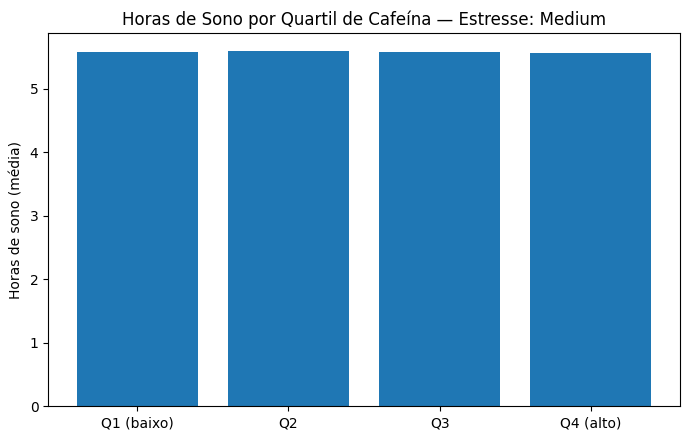

/tmp/ipython-input-3263683981.py:128: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_q = sub.groupby("Caffeine_Quartile")[col_sleep].mean()


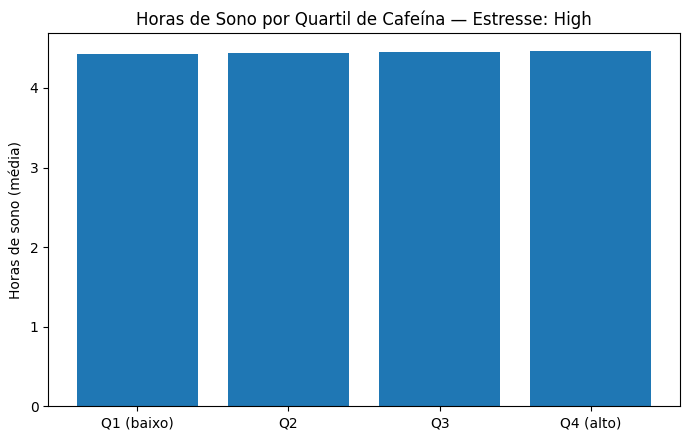

/tmp/ipython-input-3263683981.py:138: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_sq = df.pivot_table(index=col_stress, columns="Caffeine_Quartile", values="_SQ_Ord", aggfunc="mean")


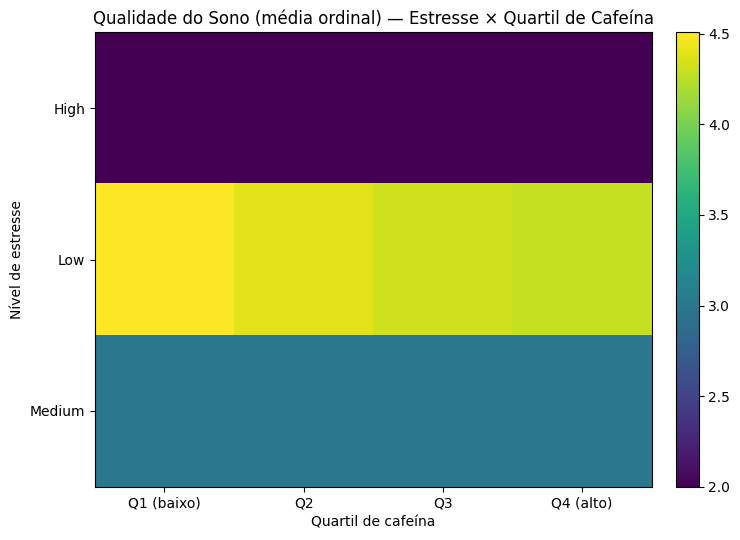

=== Principais Descobertas ===
1. Clientes com alto consumo de cafeína (Q4) dormem em média 0.59 horas a menos do que os de baixo consumo (Q1). (Q1=6.93h, Q4=6.33h)
2. Qualidade do sono decai com estresse: de High para Low, a média ordinal muda em 2.39 ponto(s).
3. Diferenças por gênero: Male dorme ~0.04h a mais que Other (média).
4. O impacto do estresse no sono varia por idade: na faixa 30–39, baixa vs alta tensão difere ~2.86h (média).

[Visualizações e descobertas geradas.]


/tmp/ipython-input-3263683981.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_age_low  = df[df["_Stress_Ord"]==df["_Stress_Ord"].min()].groupby("Age_Group")[col_sleep].mean()
/tmp/ipython-input-3263683981.py:180: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_age_high = df[df["_Stress_Ord"]==df["_Stress_Ord"].max()].groupby("Age_Group")[col_sleep].mean()


In [2]:
# ============================================================
# Visualizações & Insights — Health&Life Analytics
# Objetivo: comunicar como cafeína, estresse e fatores demográficos impactam o sono
# Regras: matplotlib puro (sem seaborn), 1 gráfico por figura, sem cores explícitas
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) Carregar e preparar
# -------------------------
FILE = "synthetic_coffee_health_10000(in).csv"  # ajuste se necessário
df = pd.read_csv(FILE)

# Util: detectar nomes de colunas mesmo que mudem levemente
def guess(df, keys):
    m = {c.lower(): c for c in df.columns}
    for k in keys:
        if k.lower() in m: return m[k.lower()]
    for c in df.columns:
        if any(k in c.lower() for k in keys): return c
    return None

col_coffee = guess(df, ["caffeine_mg","coffee","coffee_intake","coffee_cups","coffee_cups_per_day"])
col_sleep  = guess(df, ["sleep_hours","sleep_duration","hours_of_sleep"])
col_stress = guess(df, ["stress_level","stress"])
col_sq     = guess(df, ["sleep_quality","sleep_score","sleep_rating"])
col_gender = guess(df, ["gender","sexo"])
col_age    = guess(df, ["age","idade"])

# Converter ordinais (p.ex., Stress_Level e Sleep_Quality) para escala numérica
def to_ordinal(name, s: pd.Series):
    if pd.api.types.is_numeric_dtype(s): return s
    s_num = pd.to_numeric(s, errors="coerce")
    if s_num.notna().mean() > 0.8: return s_num
    vals = s.astype(str).str.strip().str.lower()
    name_l = name.lower()
    if "stress" in name_l:
        orders = [["very low","low","moderate","high","very high"], ["low","medium","high"]]
        for order in orders:
            if set(vals.unique()).issubset(set(order)) or set(order).issubset(set(vals.unique())):
                return vals.map({lab:i+1 for i,lab in enumerate(order)})
    if "sleep" in name_l and "quality" in name_l:
        orders = [["very poor","poor","fair","good","very good","excellent"],
                  ["poor","fair","good","very good","excellent"], ["1","2","3","4","5"]]
        for order in orders:
            if set(vals.unique()).issubset(set(order)) or set(order).issubset(set(vals.unique())):
                return vals.map({lab:i+1 for i,lab in enumerate(order)})
    # fallback: códigos inteiros (não garante ordem semântica)
    return pd.Series(pd.Categorical(vals).codes + 1, index=s.index, name=s.name)

stress_num = to_ordinal(col_stress, df[col_stress]) if col_stress else None
sq_num     = to_ordinal(col_sq,     df[col_sq])     if col_sq     else None

# Bins de idade (faixas gerenciais) e quartis de cafeína
if col_age:
    df["Age_Group"] = pd.cut(df[col_age], bins=[18,30,40,50,120],
                             labels=["18–29","30–39","40–49","50+"], right=False, include_lowest=True)
else:
    df["Age_Group"] = "N/A"

if col_coffee:
    df["Caffeine_Quartile"] = pd.qcut(df[col_coffee], q=4,
                                      labels=["Q1 (baixo)","Q2","Q3","Q4 (alto)"], duplicates="drop")

# -------------------------
# 2) Visualizações
# -------------------------
def box_by_category(series_num, series_cat, title):
    data = [series_num[series_cat==g].dropna().values for g in series_cat.dropna().unique()]
    labels = [str(g) for g in series_cat.dropna().unique()]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, vert=True, labels=labels, showmeans=True)
    plt.title(title); plt.ylabel(series_num.name); plt.xlabel(series_cat.name)
    plt.tight_layout(); plt.show()

def bar_means_with_se(series_num, series_cat, title):
    g = pd.concat({"x": series_num, "g": series_cat}, axis=1).dropna()
    means = g.groupby("g")["x"].mean().sort_index()
    cnt   = g.groupby("g")["x"].count().sort_index()
    std   = g.groupby("g")["x"].std().sort_index()
    se    = (std/np.sqrt(cnt)).reindex(means.index)
    plt.figure(figsize=(7,4.5))
    plt.bar(range(len(means.index)), means.values, yerr=se.values)
    plt.xticks(range(len(means.index)), [str(i) for i in means.index])
    plt.title(title); plt.ylabel(f"{series_num.name} (média)"); plt.tight_layout(); plt.show()

def heatmap_from_pivot(pivot, title, xlabel, ylabel):
    plt.figure(figsize=(7.5,5.5))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.xticks(range(pivot.shape[1]), [str(c) for c in pivot.columns])
    plt.yticks(range(pivot.shape[0]), [str(i) for i in pivot.index])
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

# 2.1 Diferenças de sono por gênero (boxplot + barras com erro-padrão)
if col_gender and col_sleep:
    box_by_category(df[col_sleep], df[col_gender], "Horas de Sono por Gênero — Boxplot")
    bar_means_with_se(df[col_sleep], df[col_gender], "Média de Horas de Sono por Gênero (± erro-padrão)")

# 2.2 Dispersão Idade vs Cafeína com linha de tendência
if col_age and col_coffee:
    sub = df[[col_age, col_coffee]].dropna()
    plt.figure(figsize=(7,5))
    plt.scatter(sub[col_age], sub[col_coffee], alpha=0.6)
    m, b = np.polyfit(sub[col_age], sub[col_coffee], 1)
    xs = np.linspace(sub[col_age].min(), sub[col_age].max(), 100)
    plt.plot(xs, m*xs + b)
    plt.title("Idade vs Cafeína (mg) — dispersão com tendência")
    plt.xlabel(col_age); plt.ylabel(col_coffee)
    plt.tight_layout(); plt.show()

# 2.3 Heatmap: média de horas de sono por faixa etária × estresse (ordinal)
if col_sleep and col_stress:
    df["_Stress_Ord"] = stress_num if stress_num is not None else pd.to_numeric(df[col_stress], errors="coerce")
    pivot_sono = df.pivot_table(index="Age_Group", columns="_Stress_Ord", values=col_sleep, aggfunc="mean")
    heatmap_from_pivot(pivot_sono, "Média de Horas de Sono — Faixa Etária × Nível de Estresse (ordinal)",
                       "Nível de estresse (baixo→alto)", "Faixa etária")

# 2.4 Barras: sono por quartil de cafeína, segmentado por estresse (3 níveis mais comuns)
if col_coffee and col_sleep and col_stress:
    for lvl in df[col_stress].value_counts().index.tolist()[:3]:
        sub = df[df[col_stress]==lvl]
        if "Caffeine_Quartile" not in sub or sub["Caffeine_Quartile"].isna().all(): continue
        means_q = sub.groupby("Caffeine_Quartile")[col_sleep].mean()
        plt.figure(figsize=(7,4.5))
        plt.bar(range(len(means_q.index)), means_q.values)
        plt.xticks(range(len(means_q.index)), [str(i) for i in means_q.index])
        plt.title(f"Horas de Sono por Quartil de Cafeína — Estresse: {lvl}")
        plt.ylabel("Horas de sono (média)"); plt.tight_layout(); plt.show()

# 2.5 Heatmap: qualidade do sono (média ordinal) por estresse × quartil de cafeína
if col_sq and col_stress and col_coffee:
    df["_SQ_Ord"] = sq_num if sq_num is not None else pd.to_numeric(df[col_sq], errors="coerce")
    pivot_sq = df.pivot_table(index=col_stress, columns="Caffeine_Quartile", values="_SQ_Ord", aggfunc="mean")
    heatmap_from_pivot(pivot_sq, "Qualidade do Sono (média ordinal) — Estresse × Quartil de Cafeína",
                       "Quartil de cafeína", "Nível de estresse")

# -------------------------
# 3) Principais Descobertas (texto com números)
# -------------------------
insights = []

# 3.1 Alto vs Baixo consumo de cafeína → horas de sono
if col_coffee and col_sleep:
    q = pd.qcut(df[col_coffee], q=4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
    mean_q1 = df.loc[q=="Q1", col_sleep].mean()
    mean_q4 = df.loc[q=="Q4", col_sleep].mean()
    if pd.notna(mean_q1) and pd.notna(mean_q4):
        diff = mean_q4 - mean_q1
        insights.append(f"Clientes com alto consumo de cafeína (Q4) dormem em média {abs(diff):.2f} horas "
                        f"{'a menos' if diff < 0 else 'a mais'} do que os de baixo consumo (Q1). "
                        f"(Q1={mean_q1:.2f}h, Q4={mean_q4:.2f}h)")

# 3.2 Estresse → qualidade do sono (média ordinal)
if col_stress and col_sq:
    sq_ord = to_ordinal(col_sq, df[col_sq])
    means = pd.DataFrame({"stress": df[col_stress], "sq": sq_ord}).dropna().groupby("stress")["sq"].mean().sort_values()
    if len(means) >= 2:
        lo, hi = means.index[0], means.index[-1]
        diff = means.iloc[-1] - means.iloc[0]
        insights.append(f"Qualidade do sono decai com estresse: de {lo} para {hi}, a média ordinal muda em {diff:.2f} ponto(s).")

# 3.3 Diferenças de sono por gênero
if col_gender and col_sleep:
    g_mean = df.groupby(col_gender)[col_sleep].mean().sort_values(ascending=False)
    if len(g_mean) >= 2:
        top, bot = g_mean.index[0], g_mean.index[-1]
        diff = g_mean.iloc[0] - g_mean.iloc[-1]
        insights.append(f"Diferenças por gênero: {top} dorme ~{diff:.2f}h a mais que {bot} (média).")

# 3.4 Interação idade × estresse → horas de sono (comparando extremos de estresse)
if col_age and col_stress and col_sleep:
    s_ord = to_ordinal(col_stress, df[col_stress])
    df["_Stress_Ord"] = s_ord
    by_age_low  = df[df["_Stress_Ord"]==df["_Stress_Ord"].min()].groupby("Age_Group")[col_sleep].mean()
    by_age_high = df[df["_Stress_Ord"]==df["_Stress_Ord"].max()].groupby("Age_Group")[col_sleep].mean()
    comp = (by_age_low - by_age_high).dropna()
    if not comp.empty:
        g = comp.abs().idxmax()
        insights.append(f"O impacto do estresse no sono varia por idade: na faixa {g}, "
                        f"baixa vs alta tensão difere ~{comp.loc[g]:.2f}h (média).")

print("=== Principais Descobertas ===")
for i, txt in enumerate(insights, 1):
    print(f"{i}. {txt}")
print("\n[Visualizações e descobertas geradas.]")
